In [1]:
'''Q1 part 1'''
'''FASTA to Flat File Converter'''
import numpy as np

def fasta_to_flatfile(fasta_file, flatfile):
    '''Converts a FASTA file to a flat file'''
    with open(fasta_file, 'r') as fasta:
        with open(flatfile, 'w') as flat:
            line_num = 1
            for line in fasta:
                if line.startswith('>'):
                    flat.write("DEFINITION  " + line[1:] + "\nORIGIN\n")
                else:
                    entire_seq = ""
                    # read lines into a single string until a new header is found
                    while (line.startswith('>') == False):
                        line = line.lower()
                        entire_seq += line.strip()
                        line = fasta.readline()
                        if line == "":
                            break
                    # split the string into chunks of 60 characters
                    seq_chunks = [entire_seq[i:i+60] for i in range(0, len(entire_seq), 60)]
                    # write the chunks to the flat file in chunks of 10
                    for chunk in seq_chunks:
                        flat.write(" " + str(line_num) + " " + chunk[0:10] + " " + chunk[10:20] + " " + chunk[20:30] + " " + chunk[30:40] + " " + chunk[40:50] + " " + chunk[50:60] + "\n")
                        line_num += 60
                    line_num = 1
                    flat.write("//\n")
                    


In [2]:
fasta_to_flatfile('NC_045512.fasta', 'sequence.flat')

In [4]:
'''Q1 part 2'''
'''flatfile to FASTA Converter'''

def flatfile_to_fasta(flatfile, fasta_file):
    '''converts a flat file to a FASTA file'''
    with open(flatfile, 'r') as flat:
        with open(fasta_file, 'w') as fasta:
            entire_seq = ""
            for line in flat:
                if line.startswith('DEFINITION'):
                    fasta.write(">" + line[12:])
                elif line.startswith('ORIGIN'):
                    while (line.startswith('//') == False):
                        line = line.upper()
                        line = flat.readline()
                        line = line.strip()
                        if line.startswith('//'):
                            break
                        # add only if not a number
                        for word in line.split():
                            if word.isdigit() == False:
                                word = word.upper()
                                entire_seq += word
                else:
                    continue
            # split the string into chunks of 70 characters
            seq_chunks = [entire_seq[i:i+70] for i in range(0, len(entire_seq), 70)]
            # write the chunks to the FASTA file
            for chunk in seq_chunks:
                fasta.write(chunk + "\n")
            

In [5]:
flatfile_to_fasta('NC_045512.gb', 'sequence.fasta')

In [6]:
'''Q2'''
'''function to parse the FEATURES from a flat file'''

def parse_features(flatfile):
    '''parses the FEATURES section of a flat file'''
    with open(flatfile, 'r') as flat:
        for line in flat:
            if line.startswith('FEATURES'):
                line = flat.readline()
                list_of_features = []
                while (line.startswith('ORIGIN') == False):
                    feature = []
                    if line[5] != ' ':
                        line = line.strip()
                        words = line.split()
                        feature.append(words[0]) # feature name
                        feature.append(words[1]) # start position
                        line = flat.readline()
                        while (line[5] == ' '):
                            if line[21] == '/':
                                line = line.strip()
                                # remove first character
                                line = line[1:]
                                # words = line.split()
                                feature.append(line)                            
                                line = flat.readline()
                            else:
                                # add this line to the last list entry
                                feature[-1] += line.strip()
                                line = flat.readline()
                        list_of_features.append(feature)
                    else:
                        line = flat.readline()
                return list_of_features

In [7]:
list_of_features = parse_features('NC_045512.gb')
# print the list of features
for feature in list_of_features:
    # print(feature)
    print("\nFeature name: " + feature[0])
    print("Position : " + feature[1])    
    for i in range(2, len(feature)):
        print("  " + feature[i])

# write the list of features to a file
with open('parsed_features.txt', 'w') as features:
    for feature in list_of_features:
        features.write("\n\nFeature name: " + feature[0])
        features.write("\nPosition : " + feature[1])    
        for i in range(2, len(feature)):
            features.write("\n  " + feature[i])

'''PLEASE VIEW THE OUTPUT IN parsed_features.txt IF IT EXCEEDS THE SIZE LIMIT OF THE OUTPUT BOX'''


Feature name: source
Position : 1..29903
  organism="Severe acute respiratory syndrome coronavirus2"
  mol_type="genomic RNA"
  isolate="Wuhan-Hu-1"
  host="Homo sapiens"
  db_xref="taxon:2697049"
  country="China"
  collection_date="Dec-2019"

Feature name: 5'UTR
Position : 1..265

Feature name: gene
Position : 266..21555
  gene="ORF1ab"
  locus_tag="GU280_gp01"
  db_xref="GeneID:43740578"

Feature name: CDS
Position : join(266..13468,13468..21555)
  gene="ORF1ab"
  locus_tag="GU280_gp01"
  ribosomal_slippage
  note="pp1ab; translated by -1 ribosomal frameshift"
  codon_start=1
  product="ORF1ab polyprotein"
  protein_id="YP_009724389.1"
  db_xref="GeneID:43740578"
  translation="MESLVPGFNEKTHVQLSLPVLQVRDVLVRGFGDSVEEVLSEARQHLKDGTCGLVEVEKGVLPQLEQPYVFIKRSDARTAPHGHVMVELVAELEGIQYGRSGETLGVLVPHVGEIPVAYRKVLLRKNGNKGAGGHSYGADLKSFDLGDELGTDPYEDFQENWNTKHSSGVTRELMRELNGGAYTRYVDNNFCGPDGYPLECIKDLLARAGKASCTLSEQLDFIDTKRGVYCCREHEHEIAWYTERSEKSYELQTPFEIKLAKKFDTFNGECPNFVFPLNSIIKTIQPRVEKKKLDGFMGRIRSVYPVASP

'PLEASE VIEW THE OUTPUT IN parsed_features.txt IF IT EXCEEDS THE SIZE LIMIT OF THE OUTPUT BOX'

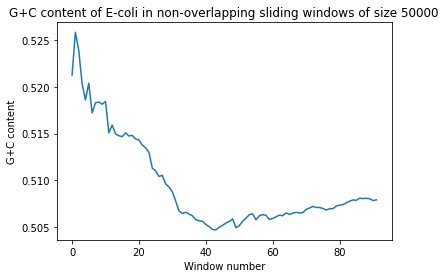

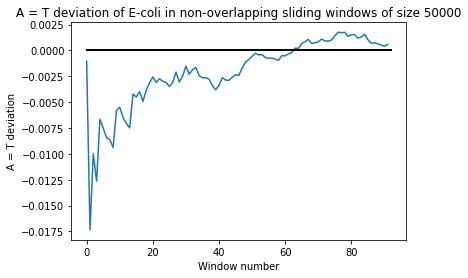

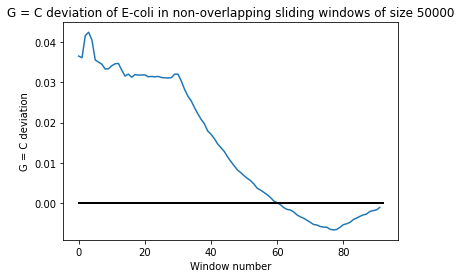

In [8]:
'''Q3'''
import matplotlib.pyplot as plt
import numpy as np

# read gemome from fasta file
with open('e-coli.fasta', 'r') as fasta:
    genome = ""
    for line in fasta:
        if line.startswith('>'):
            continue
        else:
            genome += line.strip()

genome = genome.lower()

# part 1 G+C content (non-overlapping sliding windows of size 50000)

def gc_content(genome, window_size):
    '''calculates the G+C content of a genome in non-overlapping sliding windows of size window_size'''
    # calculate the number of windows
    num_windows = int(len(genome) / window_size)
    # initialize an array to store the G+C content of each window
    gc_content = np.zeros(num_windows)
    
    cumulative_gc_count = 0
    
    for i in range(0, num_windows-1):
        # get the window
        window = genome[i*window_size:(i+1)*window_size]
        # count the number of G's and C's
        cumulative_gc_count = cumulative_gc_count + window.count('g') + window.count('c')
        # gc_count = window.count('g') + window.count('c')
        # calculate the G+C content
        gc_content[i] = cumulative_gc_count / (window_size * (i+1))
        # gc_content[i] = gc_count / window_size
    # handle the last window
    window = genome[(num_windows-1)*window_size:]
    cumulative_gc_count = cumulative_gc_count + window.count('g') + window.count('c')
    # gc_count = window.count('g') + window.count('c')
    gc_content[num_windows-1] = cumulative_gc_count / (len(genome))
    # gc_content[num_windows-1] = gc_count / len(window)
    return gc_content

gc_content = gc_content(genome, 50000)
plt.plot(gc_content)
plt.xlabel('Window number')
plt.ylabel('G+C content')
plt.title('G+C content of E-coli in non-overlapping sliding windows of size 50000')
plt.show()

# part 2 A = T deviation (non-overlapping sliding windows of size 50000)

def at_deviation(genome, window_size):
    '''calculates the A = T deviation of a genome in non-overlapping sliding windows of size window_size'''
    # calculate the number of windows
    num_windows = int(len(genome) / window_size)
    # initialize an array to store the A = T deviation of each window
    at_deviation = np.zeros(num_windows)
    
    cumulative_a_count = 0
    cumulative_t_count = 0

    for i in range(0, num_windows-1):
        # get the window
        window = genome[i*window_size:(i+1)*window_size]
        # count the number of A's and T's
        cumulative_a_count = cumulative_a_count + window.count('a')
        # a_count = window.count('a')
        cumulative_t_count = cumulative_t_count + window.count('t')
        # t_count = window.count('t')
        # calculate the A = T deviation
        at_deviation[i] = (cumulative_a_count - cumulative_t_count) / (cumulative_a_count + cumulative_t_count)
        # at_deviation[i] = (a_count - t_count) / (a_count + t_count)
    # handle the last window
    
    window = genome[(num_windows-1)*window_size:]
    cumulative_a_count = cumulative_a_count + window.count('a')
    # a_count = window.count('a')
    cumulative_t_count = cumulative_t_count + window.count('t')
    # t_count = window.count('t')
    at_deviation[num_windows-1] = (cumulative_a_count - cumulative_t_count) / (cumulative_a_count + cumulative_t_count)
    # at_deviation[num_windows-1] = (a_count - t_count) / (a_count + t_count)
    return at_deviation

at_deviation = at_deviation(genome, 50000)
plt.plot(at_deviation)
plt.plot([0, int(len(genome)/50000)], [0, 0], 'k-', lw=2)
plt.xlabel('Window number')
plt.ylabel('A = T deviation')
plt.title('A = T deviation of E-coli in non-overlapping sliding windows of size 50000')
plt.show() 

# part G = C deviation (non-overlapping sliding windows of size 50000)

def gc_deviation(genome, window_size):
    '''calculates the G = C deviation of a genome in non-overlapping sliding windows of size window_size'''
    # calculate the number of windows
    num_windows = int(len(genome) / window_size)
    # initialize an array to store the G = C deviation of each window
    gc_deviation = np.zeros(num_windows)
    
    cumulative_g_count = 0
    cumulative_c_count = 0

    for i in range(0, num_windows-1):
        # get the window
        window = genome[i*window_size:(i+1)*window_size]
        # count the number of G's and C's
        cumulative_g_count = cumulative_g_count + window.count('g')
        # g_count = window.count('g')
        cumulative_c_count = cumulative_c_count + window.count('c')
        # c_count = window.count('c')
        # calculate the G = C deviation
        gc_deviation[i] = (cumulative_g_count - cumulative_c_count) / (cumulative_g_count + cumulative_c_count)
        # gc_deviation[i] = (g_count - c_count) / (g_count + c_count)
    # handle the last window
    
    window = genome[(num_windows-1)*window_size:]
    cumulative_g_count = cumulative_g_count + window.count('g')
    # g_count = window.count('g')
    cumulative_c_count = cumulative_c_count + window.count('c')
    # c_count = window.count('c')
    gc_deviation[num_windows-1] = (cumulative_g_count - cumulative_c_count) / (cumulative_g_count + cumulative_c_count)
    # gc_deviation[num_windows-1] = (g_count - c_count) / (g_count + c_count)
    return gc_deviation

gc_deviation = gc_deviation(genome, 50000)
plt.plot(gc_deviation)
plt.plot([0, int(len(genome)/50000)], [0, 0], 'k-', lw=2)
plt.xlabel('Window number')
plt.ylabel('G = C deviation')
plt.title('G = C deviation of E-coli in non-overlapping sliding windows of size 50000')
plt.show()


In [14]:
'''Q6'''
blossum62 = [
    [4, 0, -2, -1, -2, 0, -2, -1, -1, -1, -1, -2, -1, -1, -1, 1, 0, 0, -3, -2],
    [0, 9, -3, -4, -2, -3, -3, -1, -3, -1, -1, -3, -3, -3, -3, -1, -1, -1, -2, -2],
    [-2, -3, 6, 2, -3, -1, -1, -3, -1, -4, -3, 1, -1, 0, -2, 0, -1, -3, -4, -3],
    [-1, -4, 2, 5, -3, -2, 0, -3, 1, -3, -2, 0, -1, 2, 0, 0, -1, -2, -3, -2],
    [-2, -2, -3, -3, 6, -3, -1, 0, -3, 0, 0, -3, -4, -3, -3, -2, -2, -1, 1, 3],
    [0, -3, -1, -2, -3, 6, -2, -4, -2, -4, -3, 0, -2, -2, -2, 0, -2, -3, -2, -3],
    [-2, -3, -1, 0, -1, -2, 8, -3, -1, -3, -2, 1, -2, 0, 0, -1, -2, -3, -2, 2],
    [-1, -1, -3, -3, 0, -4, -3, 4, -3, 2, 1, -3, -3, -3, -3, -2, -1, 3, -3, -1],
    [-1, -3, -1, 1, -3, -2, -1, -3, 5, -2, -1, 0, -1, 1, 2, 0, -1, -2, -3, -2],
    [-1, -1, -4, -3, 0, -4, -3, 2, -2, 4, 2, -3, -3, -2, -2, -2, -1, 1, -2, -1],
    [-1, -1, -3, -2, 0, -3, -2, 1, -1, 2, 5, -2, -2, 0, -1, -1, -1, 1, -1, -1],
    [-2, -3, 1, 0, -3, 0, 1, -3, 0, -3, -2, 6, -2, 0, 0, 1, 0, -3, -4, -2],
    [-1, -3, -1, -1, -4, -2, -2, -3, -1, -3, -2, -2, 7, -1, -2, -1, -1, -2, -4, -3],
    [-1, -3, 0, 2, -3, -2, 0, -3, 1, -2, 0, 0, -1, 5, 1, 0, -1, -2, -2, -1],
    [-1, -3, -2, 0, -3, -2, 0, -3, 2, -2, -1, 0, -2, 1, 5, -1, 0, -3, -3, -2],
    [1, -1, 0, 0, -2, 0, -1, -2, 0, -2, -1, 1, -1, 0, -1, 4, 1, -2, -3, -2],
    [0, -1, -1, -1, -2, -2, -2, -1, -1, -1, -1, 0, -1, -1, -1, 1, 5, 0, -2, -2],
    [0, -1, -3, -2, -1, -3, -3, 3, -2, 1, 1, -3, -2, -2, -3, -2, 0, 4, -3, -1],
    [-3, -2, -4, -3, 1, -2, -2, -3, -3, -2, -1, -4, -4, -2, -3, -3, -2, -3, 11, 2],
    [-2, -2, -3, -2, 3, -3, 2, -1, -2, -1, -1, -2, -3, -1, -2, -2, -2, -1, 2, 7],
]


nuc_matrix = [
    [1, -3, -3, -3],
    [-3, 1, -3, -3],
    [-3, -3, 1, -3],
    [-3, -3, -3, 1],
]

nucleotide_list = ['A', 'T', 'C', 'G']
aa_list = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']


# Needleman-Wunsch algorithm for global alignment

def needleman_wunsch(seq1, seq2, gap_penalty, substitution_matrix, res_list):
    # initialize matrix
    # matrix = [[0 for x in range(len(seq1) + 1)] for y in range(len(seq2) + 1)]
    matrix = np.zeros((len(seq1)+1, len(seq2)+1))
    # fill matrix
    for i in range(1, len(seq1) + 1):
        for j in range(1, len(seq2) + 1):
            # print(i, j)
            # print(seq1[i-1], seq2[j-1])
            # print(substitution_matrix[aa_list.index(seq1[i-1])][aa_list.index(seq2[j-1])])
            match = matrix[i - 1, j - 1] + substitution_matrix[res_list.index(seq1[i-1])][res_list.index(seq2[j-1])]
            delete = matrix[i - 1, j] + gap_penalty
            insert = matrix[i, j - 1] + gap_penalty
            matrix[i, j] = max(match, delete, insert)
    # print(matrix)
    return matrix

def smith_waterman(seq1, seq2, gap_penalty, substitution_matrix, res_list):
    # initialize matrix
    # matrix = [[0 for x in range(len(seq1) + 1)] for y in range(len(seq2) + 1)]
    matrix = np.zeros((len(seq1)+1, len(seq2)+1))
    # fill matrix
    for i in range(1, len(seq1) + 1):
        for j in range(1, len(seq2) + 1):
            # print(i, j)
            # print(seq1[i-1], seq2[j-1])
            # print(substitution_matrix[aa_list.index(seq1[i-1])][aa_list.index(seq2[j-1])])
            match = matrix[i - 1, j - 1] + substitution_matrix[res_list.index(seq1[i-1])][res_list.index(seq2[j-1])]
            delete = matrix[i - 1, j] + gap_penalty
            insert = matrix[i, j - 1] + gap_penalty
            matrix[i, j] = max(0, match, delete, insert)
    # print(matrix)
    return matrix




In [17]:
aa_gap_penalty = -11
nuc_gap_penalty = -3

# read from file
with open('spike_cov_nuc.txt', 'r') as f:
    seq1 = f.read().replace('\n', '')

with open('spike_cov2_nuc.txt', 'r') as f:
    seq2 = f.read().replace('\n', '')

# with open('spike_cov_aa.txt', 'r') as f:
#     seq3 = f.read().replace('\n', '')

# with open('spike_cov2_aa.txt', 'r') as f:
#     seq4 = f.read().replace('\n', '')

seq3 = 'AADCKDKSDEENCAVTTCRPDEFQCADGSCIHGSRQ'
seq4 = 'QCDDGSCIHG'

# seq1 = 'C T C T A G C A T T A G'
# seq2 = 'G T G C A C C C A '
# # seq2 = ' A G C '

# seq3 = 'VHLTPEEKSAVTALWG'
# seq4 = 'VAFTEKQEALVSSSLEAF'

seq1 = seq1.replace(' ', '')
seq2 = seq2.replace(' ', '')
seq3 = seq3.replace(' ', '')
seq4 = seq4.replace(' ', '')

seq1 = seq1.upper()
seq2 = seq2.upper()
seq3 = seq3.upper()
seq4 = seq4.upper()

mat_g_n = (needleman_wunsch(seq1, seq2, nuc_gap_penalty, nuc_matrix, nucleotide_list))
mat_g_w = (smith_waterman(seq1, seq2, nuc_gap_penalty, nuc_matrix, nucleotide_list))
mat_a_n = (needleman_wunsch(seq3, seq4, aa_gap_penalty, blossum62, aa_list))
mat_a_w = (smith_waterman(seq3, seq4, aa_gap_penalty, blossum62, aa_list))

# print("yes")
# write alignment of seq1 and seq2 to file
def write_alignment_needle(seq1, seq2, matrix, gap_penalty ,filename, substitution_matrix, res_list):
    # open file for writing
    f = open(filename, 'w')
    # initialize variables
    alignment1, alignment2 = '', ''
    i, j = len(seq1), len(seq2)
    # traceback
    while i > 0 and j > 0:
        score = matrix[i, j]
        score_diagonal = matrix[i - 1, j - 1]
        score_up = matrix[i, j - 1]
        score_left = matrix[i - 1, j]
        if score == score_diagonal + substitution_matrix[res_list.index(seq1[i-1])][res_list.index(seq2[j-1])]:
            alignment1 += seq1[i - 1]
            alignment2 += seq2[j - 1]
            i -= 1
            j -= 1
        elif score == score_left + gap_penalty:
            alignment1 += seq1[i - 1]
            alignment2 += '-'
            i -= 1
        elif score == score_up + gap_penalty:
            alignment1 += '-'
            alignment2 += seq2[j - 1]
            j -= 1
    # finish tracing up to the top left cell
    while i > 0:
        alignment1 += seq1[i - 1]
        alignment2 += '-'
        i -= 1
    while j > 0:
        alignment1 += '-'
        alignment2 += seq2[j - 1]
        j -= 1
    # write alignments to file
    f.write(alignment1[::-1] + '\n')
    f.write(alignment2[::-1] + '\n')
    f.close()

def write_alignment_water(seq1, seq2, matrix, gap_penalty ,filename, substitution_matrix, res_list):
    # open file for writing
    f = open(filename, 'w')
    # initialize variables
    alignment1, alignment2 = '', ''
    # i, j = len(seq1), len(seq2)
    max_score = 0
    max_i = 0
    max_j = 0
    for i in range(len(seq1) + 1):
        for j in range(len(seq2) + 1):
            if matrix[i, j] > max_score:
                max_score = matrix[i, j]
                max_i = i
                max_j = j
    
    # traceback
    i = max_i
    j = max_j
    while i > 0 and j > 0:
        score = matrix[i, j]
        score_diagonal = matrix[i - 1, j - 1]
        score_up = matrix[i, j - 1]
        score_left = matrix[i - 1, j]
        if score == 0:
            break
        if score == score_diagonal + substitution_matrix[res_list.index(seq1[i-1])][res_list.index(seq2[j-1])]:
            alignment1 += seq1[i - 1]
            alignment2 += seq2[j - 1]
            i -= 1
            j -= 1
        elif score == score_left + gap_penalty:
            alignment1 += seq1[i - 1]
            alignment2 += '-'
            i -= 1
        elif score == score_up + gap_penalty:
            alignment1 += '-'
            alignment2 += seq2[j - 1]
            j -= 1
    
    # write alignments to file
    f.write(alignment1[::-1] + '\n')
    f.write(alignment2[::-1] + '\n')
    f.close()


write_alignment_needle(seq1, seq2, mat_g_n, nuc_gap_penalty, 'alignment_gene_needle.txt', nuc_matrix, nucleotide_list)
write_alignment_water(seq1, seq2, mat_g_w, nuc_gap_penalty , 'alignment_gene_smith.txt', nuc_matrix, nucleotide_list)
write_alignment_needle(seq3, seq4, mat_a_n, aa_gap_penalty , 'alignment_aa_needle.txt', blossum62, aa_list)
write_alignment_water(seq3, seq4, mat_a_w, aa_gap_penalty , 'alignment_aa_smith.txt', blossum62, aa_list)

'''Accession ID of SARS CoV-2 Spike Gene: NC_045512.2'''
'''Accession ID of SARS CoV-2 Spike Protein: YP_009724390.1'''
'''Accession ID of SARS CoV Spike Gene: NC_004718.3'''
'''Accession ID of SARS CoV Spike Protein: YP_009825051.1'''


'''Also, upon comparision with the alignment given by Emboss for the same cases, it can be seen that they are similar. They are not exactly
the same, because EMBOSS uses a gap extension penalty, whereas I used a linear gap penalty.'''

'Also, upon comparision with the alignment given by Emboss for the same cases, it can be seen that they are similar. They are not exactly\nthe same, because EMBOSS uses a gap extension penalty, whereas I used a linear gap penalty.'

In [9]:
'''Q4'''

# find most frequent 9-mers in the genome

# read genome
genome = ''
with open('vibrio_chr1.fasta', 'r') as f:
    genome = f.read().replace('\n', '')
with open('vibrio_chr2.fasta', 'r') as f:
    genome += f.read().replace('\n', '')

# write genome to file 
# f = open('genome.txt', 'w')
# f.write(genome)
# f.close()


reverse_complement = ''

for i in range(len(genome)):
    if genome[i] == 'A':
        reverse_complement += 'T'
    elif genome[i] == 'T':
        reverse_complement += 'A'
    elif genome[i] == 'C':
        reverse_complement += 'G'
    elif genome[i] == 'G':
        reverse_complement += 'C'
    else :
        reverse_complement += genome[i]

reverse_complement = reverse_complement[::-1]

# genome += reverse_complement


def find_kmers(genome, k):
    kmers = {}
    for i in range(len(genome) - k + 1):
        kmer = genome[i:i+k]
        if kmer in kmers:
            kmers[kmer] += 1
        else:
            kmers[kmer] = 1
    kmers = sorted(kmers.items(), key=lambda x: x[1], reverse=True)
    return kmers

kmer_dict = find_kmers(genome, 9)
rev_kmer_dict = find_kmers(reverse_complement, 9)

# merge the two dictionaries
merged_dict = {}
for kmer in kmer_dict:
    merged_dict[kmer[0]] = kmer[1]
for kmer in rev_kmer_dict:
    if kmer[0] in merged_dict:
        merged_dict[kmer[0]] += kmer[1]
    else:
        merged_dict[kmer[0]] = kmer[1]

merged_dict = sorted(merged_dict.items(), key=lambda x: x[1], reverse=True)

# print the 20 most frequent 9-mers
print('The 20 most frequent 9-mers in Vibrio Cholerae are:')
for i in range(20):
    print(merged_dict[i])


sal_gen = ''
with open('salmonella.fasta', 'r') as f:
    sal_gen = f.read().replace('\n', '')

# reverse complement
sal_rev = ''
for i in range(len(sal_gen)):
    if sal_gen[i] == 'A':
        sal_rev += 'T'
    elif sal_gen[i] == 'T':
        sal_rev += 'A'
    elif sal_gen[i] == 'C':
        sal_rev += 'G'
    elif sal_gen[i] == 'G':
        sal_rev += 'C'
    else :
        sal_rev += sal_gen[i]

sal_rev = sal_rev[::-1]

sal_kmer_dict = find_kmers(sal_gen, 9)
sal_rev_kmer_dict = find_kmers(sal_rev, 9)

# merge the two dictionaries
sal_merged_dict = {}
for kmer in sal_kmer_dict:
    sal_merged_dict[kmer[0]] = kmer[1]
for kmer in sal_rev_kmer_dict:
    if kmer[0] in sal_merged_dict:
        sal_merged_dict[kmer[0]] += kmer[1]
    else:
        sal_merged_dict[kmer[0]] = kmer[1]

sal_merged_dict = sorted(sal_merged_dict.items(), key=lambda x: x[1], reverse=True)

# print the 20 most frequent 9-mers
print('The 20 most frequent 9-mers in Salmonella Enterica are:')
for i in range(20):
    print(sal_merged_dict[i])



# with d mismatches

# def find_kmers_d_mismatches(genome, k, d):

'''As can be seen, the most frequent 9-mers in Vibrio Cholerae and Salmonella Enterica are very differeny. Vibrio seems to have more A T in its most frequent sequences, whereas Salmonella seems to have more G C'''


The 20 most frequent 9-mers in Vibrio Cholerae are:
('TTTGAGTTT', 272)
('AAACTCAAA', 272)
('AAAAAAGCC', 254)
('GGCTTTTTT', 254)
('CAATCGCTT', 253)
('AAGCGATTG', 253)
('AAAGCCAAA', 246)
('TTTGGCTTT', 246)
('CTTGCTCAA', 244)
('TTGAGCAAG', 244)
('GCGCTTTTT', 226)
('AAAAAGCGC', 226)
('AAAATCAGC', 224)
('CATCAATCA', 224)
('TGATTGATG', 224)
('GCTGATTTT', 224)
('TTGATGGTG', 223)
('GCGCAGCAA', 223)
('TTGCTGCGC', 223)
('CACCATCAA', 223)
The 20 most frequent 9-mers in Salmonella Enterica are:
('CGCCAGCGC', 1006)
('GCGCTGGCG', 1006)
('GCGCCAGCG', 834)
('CGCTGGCGC', 834)
('CCGCCAGCG', 779)
('CGCTGGCGG', 779)
('CAGCGCCAG', 737)
('CTGGCGCTG', 737)
('CGCCGCCGC', 724)
('GCGGCGGCG', 724)
('CTGGCGGCG', 668)
('CGCCGCCAG', 668)
('CCAGCGCCA', 652)
('TGGCGCTGG', 652)
('GCCAGCGCC', 636)
('GGCGCTGGC', 636)
('GCTGGCGGC', 623)
('GCCGCCAGC', 623)
('CCGCTGGCG', 612)
('CGCCAGCGG', 612)


'As can be seen, the most frequent 9-mers in Vibrio Cholerae and Salmonella Enterica are very differeny. Vibrio seems to have more A T in its most frequent sequences, whereas Salmonella seems to have more G C'

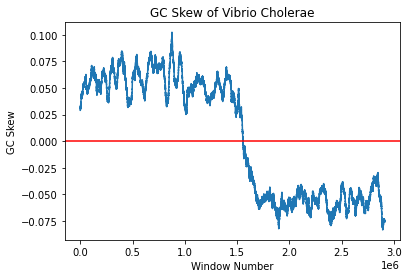

In [111]:
'''Q4 part 2'''
#  plot GC skew of the genome

# read genome
genome = ''
with open('vibrio_chr1.fasta', 'r') as f:
    genome = f.read().replace('\n', '')
# with open('vibrio_chr2.fasta', 'r') as f:
#     genome += f.read().replace('\n', '')

window_size = 50000
gc_skew = []

def calc_gc_skew(genome, window_size, gc_skew):
    # gc_skew = []
    init = genome[:window_size]
    g_count = init.count('G')
    c_count = init.count('C')
    gc_skew.append((g_count - c_count)/(g_count + c_count))
    for i in range(1, len(genome) - window_size + 1):
        if genome[i-1] == 'G':
            g_count -= 1
        elif genome[i-1] == 'C':
            c_count -= 1
        if genome[i+window_size-1] == 'G':
            g_count += 1
        elif genome[i+window_size-1] == 'C':
            c_count += 1
        gc_skew.append((g_count - c_count)/(g_count + c_count))
    
    return gc_skew

calc_gc_skew(genome, window_size, gc_skew)

plt.plot(gc_skew)
plt.xlabel('Window Number')
plt.ylabel('GC Skew')
plt.title('GC Skew of Vibrio Cholerae')
# plot y = 0
plt.axhline(y=0, color='r', linestyle='-')
plt.show()


In [112]:
'''From the graph, we see that the first tipping point comes around window 1500000. Let's see the most frequent 9-mers around that point.'''
# find the most frequent 9-mers around the first tipping point
# window 1500000
kmer_dict = find_kmers(genome[1400000:1600000], 9)
rev_kmer_dict = find_kmers(reverse_complement[1400000:1600000], 9)

# merge the two dictionaries
merged_dict = {}
for kmer in kmer_dict:
    merged_dict[kmer[0]] = kmer[1]
for kmer in rev_kmer_dict:
    if kmer[0] in merged_dict:
        merged_dict[kmer[0]] += kmer[1]
    else:
        merged_dict[kmer[0]] = kmer[1]

merged_dict = sorted(merged_dict.items(), key=lambda x: x[1], reverse=True)

# print the 20 most frequent 9-mers
print('The 20 most frequent 9-mers in Vibrio Cholerae around the first tipping point are:')
for i in range(20):
    print(merged_dict[i])


The 20 most frequent 9-mers in Vibrio Cholerae around the first tipping point are:
('AAGCGATTG', 23)
('GGTGATGGC', 20)
('GCGATTGAA', 20)
('CAAGCGATT', 20)
('AAAAACAGC', 19)
('TGATTTTGC', 19)
('AATAAAAAA', 19)
('AAGTGATTG', 19)
('AGCGATTGA', 18)
('GCGATGGCG', 18)
('GGCTTTTTT', 17)
('TGCGTGATG', 17)
('TTTTTTCAT', 17)
('GATGAAGCG', 17)
('CGATTGAAG', 17)
('GGCGATTTT', 17)
('CGATTTTGA', 17)
('TGGCGCAGA', 17)
('TTGCTGAGC', 17)
('GCGATTTTG', 17)


In [10]:
'''Q5'''

cov2genome = ''

with open('cov2genome.txt', 'r') as f:
    cov2genome = f.read().replace('\n', '')

with open('bat-cov.txt', 'r') as f:
    batcov = f.read().replace('\n', '')

cov2genome_rev = ''
for i in range(len(cov2genome)):
    if cov2genome[i] == 'A':
        cov2genome_rev += 'T'
    elif cov2genome[i] == 'T':
        cov2genome_rev += 'A'
    elif cov2genome[i] == 'C':
        cov2genome_rev += 'G'
    elif cov2genome[i] == 'G':
        cov2genome_rev += 'C'
    else :
        cov2genome_rev += cov2genome[i]

cov2genome_rev = cov2genome_rev[::-1]

cov2_dict = find_kmers(cov2genome, 6)
cov2_rev_dict = find_kmers(cov2genome_rev, 6)

# merge the two dictionaries
cov2_merged_dict = {}
for kmer in cov2_dict:
    cov2_merged_dict[kmer[0]] = kmer[1]
for kmer in cov2_rev_dict:
    if kmer[0] in cov2_merged_dict:
        cov2_merged_dict[kmer[0]] += kmer[1]
    else:
        cov2_merged_dict[kmer[0]] = kmer[1]

cov2_merged_dict = sorted(cov2_merged_dict.items(), key=lambda x: x[1], reverse=True)


# print the 20 most frequent 9-mers
print('The 20 most frequent 9-mers in SARS-CoV-2 are:')
for i in range(20):
    print(cov2_merged_dict[i])



batcov_rev = ''
for i in range(len(batcov)):
    if batcov[i] == 'A':
        batcov_rev += 'T'
    elif batcov[i] == 'T':
        batcov_rev += 'A'
    elif batcov[i] == 'C':
        batcov_rev += 'G'
    elif batcov[i] == 'G':
        batcov_rev += 'C'
    else :
        batcov_rev += batcov[i]

batcov_rev = batcov_rev[::-1]

batcov_dict = find_kmers(batcov, 6)
batcov_rev_dict = find_kmers(batcov_rev, 6)

# merge the two dictionaries

batcov_merged_dict = {}

for kmer in batcov_dict:
    batcov_merged_dict[kmer[0]] = kmer[1]
for kmer in batcov_rev_dict:
    if kmer[0] in batcov_merged_dict:
        batcov_merged_dict[kmer[0]] += kmer[1]
    else:
        batcov_merged_dict[kmer[0]] = kmer[1]

batcov_merged_dict = sorted(batcov_merged_dict.items(), key=lambda x: x[1], reverse=True)

# # print the 20 most frequent 9-mers
print('The 20 most frequent 9-mers in Bat-Cov are:')
for i in range(20):
    print(batcov_merged_dict[i])
    


The 20 most frequent 9-mers in SARS-CoV-2 are:
('TTGTTA', 70)
('TAACAA', 70)
('TTTTAA', 68)
('TTAAAA', 68)
('TGTTGT', 65)
('ACAACA', 65)
('ATTGTT', 63)
('AACAAT', 63)
('TGTTTT', 61)
('AAGAAA', 61)
('AAAACA', 61)
('TTTCTT', 61)
('TGTTAA', 59)
('ACAATT', 59)
('AATTGT', 59)
('TTAACA', 59)
('AACAAA', 58)
('TTTAAA', 58)
('TTTGTT', 58)
('TTCTTT', 56)
The 20 most frequent 9-mers in Bat-Cov are:
('TTTGTT', 59)
('AACAAA', 59)
('TGTTGT', 54)
('ACAACA', 54)
('TTGTTT', 53)
('AAACAA', 53)
('TTGTTG', 52)
('TGTTAA', 52)
('TTAACA', 52)
('CAACAA', 52)
('CTTTGT', 48)
('ACAAAG', 48)
('TTGTTA', 47)
('TAATAA', 47)
('TTATTA', 47)
('TAACAA', 47)
('TGTTGA', 46)
('TCAACA', 46)
('TAATTA', 44)
('ATTTTA', 43)


In [11]:
print("We can see that the most frequent 9-mers in SARS-CoV-2 are somehwat similar to the most frequent 9-mers in Bat-Cov. This suggests that SARS-CoV-2 has some relation to the bat virus.")
count = 0
# for item in batcov_merged_dict:
#     if item in cov2_merged_dict:
#         count += min(item[1])
for i in range(len(batcov_merged_dict)):
    if batcov_merged_dict[i] in cov2_merged_dict:
        count += batcov_merged_dict[i][1]
        # count += 1
        
print('The number of bases in 9-mers that are common to both SARS-CoV-2 and Bat-Cov is', count*9)
print("this is a considerable overlap, and thus suggests that SARS-CoV-2 has some relation to the bat virus.")

# print(intersect(cov2_merged_dict, batcov_merged_dict), 'sequences are common out of', count(cov2_merged_dict), 'and', count(batcov_merged_dict), 'genomes')


We can see that the most frequent 9-mers in SARS-CoV-2 are somehwat similar to the most frequent 9-mers in Bat-Cov. This suggests that SARS-CoV-2 has some relation to the bat virus.
The number of bases in 9-mers that are common to both SARS-CoV-2 and Bat-Cov is 28980
this is a considerable overlap, and thus suggests that SARS-CoV-2 has some relation to the bat virus.


In [12]:
# GC content of SARS-CoV-2 genome

with open('cov2genome.txt', 'r') as f:
    cov2genome = f.read().replace('\n', '')

gc_count = 0
for i in range(len(cov2genome)):
    if cov2genome[i] == 'G' or cov2genome[i] == 'C':
        gc_count += 1

print('The GC content of SARS-CoV-2 genome is: ', gc_count/len(cov2genome) * 100, '%')


The GC content of SARS-CoV-2 genome is:  37.97277865097147 %


In [13]:
'''This means that the GC content of SARS-CoV-2 genome is 37.97%, which implies that this virus does not have stability
at very high temperatures, since higher GC content means higher stability at high temperatures.'''

'This means that the GC content of SARS-CoV-2 genome is 37.97%, which implies that this virus does not have stability\nat very high temperatures, since higher GC content means higher stability at high temperatures.'